# classes

> This module has commands to handle the ```Box``` and ```Line``` classes that are loaded into and saved from the figure first outline in ```annotation```

In [ ]:
#| default_exp classes

In [4]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
from fastcore.utils import *
import csv
import os

## BBox

This class is designed to carry all the data for a ```Rectangle``` object to be drawn on ```Plotly``` figures. Details on that are in [documentation](https://plotly.com/python/shapes/). In order to instantiate a rectangle of the style we want inside of a figure, we need to run the following code:
```python
fig.add_shape(type="rect",
              x0=...,
              y0=...,
              x1=...,
              y1=...,
              line=dict(color="grey"),
              opacity=0.6,
             )
```

The dotted out variables are the ones we want to assign uniquely and the rest are class level attributes. In addition to this though, we want each ```Box``` object related to a particular image to have an index that orders it and a text line that it is assigned to. See this example.

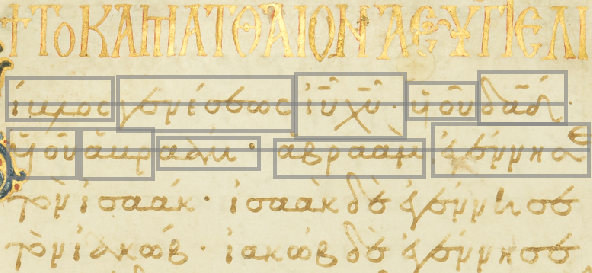

In the above example, it's easy to see that there are grey lines extending through a whole line of text and grey boxes around the words. The line which intersects with the boxes is the line that the boxes are attached to. We want to display the number of lines when annotating and getting the words on those lines indexed in order of which comes first. This motivates the instance level traits that come with a ```BBox```.

#### Class Level Traits
- ```type``` corresponds to the type of figure being added
- ```line``` is a ```dict``` containing the line color
- ```opacity``` defines the opacity of the line of the shape

#### Instance Level Traits
- ```x0``` corresponds to the $x$ coordinate of one corner
- ```y0``` corresponds to the $y$ coordinate of the same corner as $x_0$
- ```x1``` corresponds to the $x$ coordinate of the corner opposite $(x_0,y_0)$
- ```y1``` corresponds to the $y$ coordinate of the same corner as $x_1$
- ```lineNo``` defines which line the boxes are attached to
- ```index``` defines the relative ordering of the boxes on a line
- ```midpoint``` defines a midpoint between $x_0$ and $x_1$
- ```annotation``` is a value to contain a string indicating the contents of the box

First, we will set up the class itself. From here, we will patch on methods to the class.

In [5]:
#| export
class BBox:
    type = "rect"
    line = dict(color="grey")
    opacity = 0.6

### \_\_init\_\_

This method is self explanatory. It instantiates a box from a set of given points. It doesn't provide intelligible values to either the line number or index as those are defined later.

In [6]:
#| export
@patch
def __init__(self: BBox, x0, y0, x1, y1, lineNo=-1, index=-1, annotation="none"):
    self.x0 = int(x0)
    self.y0 = int(y0)
    self.x1 = int(x1)
    self.y1 = int(y1)
    self.midpoint = (self.x0 + self.x1) / 2
    self.lineNo = int(lineNo)
    self.index = int(index)
    self.annotation = annotation

### isLine

This method takes the $y$ coordinates of a ```Line``` and verifies if the points of a given box place it along the text line. If it does, the box is assigned the ```index``` of the line as its own ```lineNo``` and returns ```True```. It only takes the $y$ coordinates of a ```Line``` because the $x$ coordinates are not relevant to text lines which are only defined from top to bottom. It is worth noting that, usually, a graph has positive $y$ values associated with an upward direction. However, ```Imshow``` figures make the positive $y$ values be associated with an axis that points downwards. This counterintuitive feature, along with the fact that $y_0<y_1$ is not guaranteed means that simple less than or greater than strategies are not well suited to this problem. Instead, we will use relative distances to establish if a ```BBox``` is along a ```Line```.

Without loss of generality, assume that $y_0<y_1$ where these two values correspond to the coordinates of a ```BBox```. From here, assume that a given ```Line``` is horizontal such that there is only one relevant $y$ coordinate to describe its location relative to the $y$-axis. Though not proven, assume that a *slightly* skewed ```Line``` will have a midpoint $y$ between its two relevant coordinates that means we can approximate this ```Line``` by said midpoint as a horizontal line. Either way, we have some $y$ that we can use to describe a ```Line```. Working within the real numbers, we can say that $y\in(y_0,y_1)$ implies that $|y-y_0|<|y_0-y_1|$ and $|y-y_1|<|y_0-y_1|$. However, if $y\notin(y_0,y_1)$ and $y\neq y_0$ or $y\neq y_1$, we can say that it is necessarily true that either $|y_0-y_1|<|y-y_0|$ or $|y_0-y_1|<|y-y_1|$ (as, for example, if $y<y_0$ then $|y-y_0|+|y_0-y_1|=|y-y_1|$). This is the basis of our test.

It is possible that $y=y_0$ or $y=y_1$. These cases, while important, likely indicate a user error where the user has drawn a ```BBox``` that is too large. When these arise, the ```BBox``` will not be associated with the line.

Thus, we are testing for two conditions:
- if $|y_0-y_1|\leq|y-y_0|$ then $y\notin(y_0,y_1)$
- if $|y_0-y_1|\leq|y-y_1|$ then $y\notin(y_0,y_1)$

In [19]:
#| export
@patch
def isLine(self: BBox, line):
    y = line.midpoint
    y0 = self.y0
    y1 = self.y1
    dif = abs(y0-y1)
    
    if dif <= abs(y-y0) or dif <= abs(y-y1):
        return False
    
    self.lineNo = line.index
    
    return True

### \_\_gt\_\_, \_\_lt\_\_, and \_\_eq\_\_

These methods are necessary to sort bboxes into an order so that they can be assigned an index. They define an ordering based on the ```midpoint``` attribute.

In [21]:
#| export
@patch
def __gt__(self:BBox, other:BBox):
    return self.midpoint > other.midpoint

@patch
def __lt__(self:BBox, other:BBox):
    return self.midpoint < other.midpoint

@patch
def __eq__(self:BBox, other:BBox):
    return self.midpoint == other.midpoint

### sortBBoxes

Because we want to index the boxes drawn on the same line, we need to implement a sorting algorithm for the boxes. Using a [selection sort algorithm](https://www.geeksforgeeks.org/sorting-algorithms-in-python/), the sorting is performed on an array of ```BBox``` objects passed into the method. Once sorting is done, ```index``` values are assigned to each ```BBox``` object in the array. This method returns the sorted array.

It is assumed that all ```BBox``` objects in the argument ```list``` have the same ```lineNo```. This is handled in other modules.

This method is a class method because it has no reason to be associated to any one instance of an object but it does make sense to associate it with the ```BBox``` class.

In [20]:
#| export
@patch_to(BBox, cls_method=True)
def sortBBoxes(cls, bboxList):
    size = len(bboxList)
    
    for i in range(size):
        minimum = i
        minValueI = bboxList[minimum]
        
        for j in range(i+1, size):
            if bboxList[j] < bboxList[minimum]:
                minimum = j
                minValueJ = bboxList[minimum]
        
        if minimum != i:
            bboxList[i] = minValueJ
            bboxList[minimum] = minValueI
        
    index = 1
    for bbox in bboxList:
        bbox.index = index
        index = index + 1
        
    return bboxList

### bboxesToCSV

This is a method that takes in a ```list``` of ```BBox``` objects and prints them out to a ```csv``` file. The method is built on code from [this article](https://blog.finxter.com/how-to-convert-a-list-of-objects-to-a-csv-file-in-python-5-ways/). In order to print out the file to a specific directory and with a specific name, a directory for the file and a name for it are passed in as well.

The list ```bboxes``` will always be sorted before it is sent to this method.

This method is a class method because it operates on a list of ```BBox``` objects, not just one box. 

In [18]:
#| export
@patch_to(BBox, cls_method=True)
def bboxesToCSV(cls, targetDirectory, bboxes, fileName):
    baseDirectory = os.getcwd()
    os.chdir(targetDirectory)
    
    # Prevents an already written csv file from having unwanted data
    if os.path.exists(fileName):
        os.remove(fileName)

    f = open(fileName + ".csv", "w", newline="")
    writer = csv.writer(f)
    for bbox in bboxes:
        writer.writerow([bbox.x0, bbox.y0, bbox.x1, bbox.y1, bbox.lineNo, bbox.index, bbox.annotation])

    os.chdir(baseDirectory)

### csvToBBoxes

This is a class method that takes in a reference to a ```csv``` file and reads it to instantiate a collection of ```BBox``` objects, creating a list to contain references to the objects and returning it for use.

In [17]:
#| export
@patch_to(BBox, cls_method=True)
def csvToBBoxes(cls, targetFile):
    f = open(targetFile)
    csvReader = csv.reader(f, delimiter=",")

    bboxes = []
    for row in csvReader:
        bbox = BBox(
            x0=row[0], y0=row[1], x1=row[2], y1=row[3], lineNo=row[4], index=row[5], annotation=row[6]
        )
        bboxes.append(bbox)

    return bboxes

## Line

This class corresponds to the lines mentioned in the ```Plotly``` [documentation on shapes](https://plotly.com/python/shapes/). To instantiate a line inside of a figure, we have to use:
```python
fig.add_shape(type="line",
              x0=...,
              y0=...,
              x1=...,
              y1=...,
              line=dict(color="grey"),
              opacity=0.6,
             )
```

The dotted variables are traits that we want to assign uniquely to a ```Line``` object and the rest are class level variables. These variables, along with an ```index``` and a ```midpoint``` will help order the ```Line``` objects into an ordering necessary for the ```BBox.isLine()``` method and setting up line numbers for the ```Textarea``` from ```04_annotation.ipynb```.

#### Class Level Traits
- ```type``` corresponds to the type of figure being added
- ```line``` is a ```dict``` containing the line color
- ```opacity``` defines the opacity of the line of the shape

#### Instance Level Traits
- ```x0``` corresponds to the $x$ coordinate of one point defining the line
- ```y0``` corresponds to the $y$ coordinate of the same point as $x_0$
- ```x1``` corresponds to the $x$ coordinate of the point that isn't located at $(x_0,y_0)$
- ```y1``` corresponds to the $y$ coordinate of the same point as $x_1$
- ```index``` defines the relative ordering of the lines on a page from top to bottom
- ```midpoint``` defines a midpoint along the $y$-axis for the ```Line``` between $y_0$ and $y_1$

First, we will set up the class with class variables.

In [10]:
#| export
class Line:
    type = "line"
    line = dict(color="grey")
    opacity = 0.6

### \_\_init\_\_

This method is fairly self explanatory. It takes in a collection of points and defines a line by them, but it sets ```index``` values to values that are not intelligible.

In [11]:
#| export
@patch
def __init__(self: Line, x0, y0, x1, y1, index=-1):
    self.x0 = int(x0)
    self.y0 = int(y0)
    self.x1 = int(x1)
    self.y1 = int(y1)
    self.midpoint = (self.y0 + self.y1) / 2
    self.index = int(index)

### \_\_gt\_\_, \_\_lt\_\_, and \_\_eq\_\_

These methods are necessary to sort lines into an order so that they can be assigned an index. They define an ordering based on the ```midpoint``` attribute.

In [13]:
#| export
@patch
def __gt__(self:Line, other:Line):
    return self.midpoint > other.midpoint

@patch
def __lt__(self:Line, other:Line):
    return self.midpoint < other.midpoint

@patch
def __eq__(self:Line, other:Line):
    return self.midpoint == other.midpoint

### sortLines

Because we want to index the lines drawn on a figure, we need to implement a sorting algorithm for the lines. Using a [selection sort algorithm](https://www.geeksforgeeks.org/sorting-algorithms-in-python/), the sorting is performed on an array of ```Line``` objects passed into the method. Once sorting is done, ```index``` values are assigned to each ```Line``` object in the array. This method returns the sorted array.

The element used to compare each ```Line``` object is the ```midpoint```. The objects are sorted on this basis.

This method is a class method because it has no reason to be associated to any one instance of an object but it does make sense to associate it with the ```Line``` class.

In [14]:
#| export
@patch_to(Line, cls_method=True)
def sortLines(cls, lineList: list):
    size = len(lineList)
    
    for i in range(size):
        minimum = i
        minValueI = lineList[minimum]
        
        for j in range(i+1, size):
            if lineList[j] < lineList[minimum]:
                minimum = j
                minValueJ = lineList[minimum]
        
        if minimum != i:
            lineList[i] = minValueJ
            lineList[minimum] = minValueI
        
    index = 1
    for line in lineList:
        line.index = index
        index = index + 1
        
    return lineList

### linesToCSV

This is a method that takes in a ```list``` of ```Line``` objects and prints them out to a ```csv``` file. The method is built on code from [this article](https://blog.finxter.com/how-to-convert-a-list-of-objects-to-a-csv-file-in-python-5-ways/). In order to print out the file to a specific directory and with a specific name, a directory for the file and a name for it are passed in as well.

The list ```lines``` will always be sorted before it is passed to this method.

This method is a class method because it operates on a list of ```Line``` objects, not just one line. 

In [18]:
#| export
@patch_to(Line, cls_method=True)
def linesToCSV(cls, targetDirectory, lines, fileName):
    baseDirectory = os.getcwd()
    os.chdir(targetDirectory)
    
    # Prevents an already written csv file from having unwanted data
    if os.path.exists(fileName):
        os.remove(fileName)

    f = open(fileName + ".csv", "w", newline="")
    writer = csv.writer(f)
    for line in lines:
        writer.writerow([line.x0, line.y0, line.x1, line.y1, line.index])

    os.chdir(baseDirectory)

### csvToLines

This is a class method that takes in a reference to a ```csv``` file and reads it to instantiate a collection of ```Line``` objects, creating a list to contain references to the objects and returning it for use.

In [17]:
#| export
@patch_to(Line, cls_method=True)
def csvToLines(cls, targetFile):
    f = open(targetFile)
    csvReader = csv.reader(f, delimiter=",")

    lines = []
    for row in csvReader:
        line = Line(x0=row[0], y0=row[1], x1=row[2], y1=row[3], index=row[4])
        lines.append(line)
        
    return lines

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()